## El objetivo de este ejercicio es implementar Q-learning
<img src="Q-learning.PNG">

In [1]:
%matplotlib inline

import gym
import itertools
import matplotlib
import numpy as np
import pandas as pd
import sys

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib.envs.cliff_walking import CliffWalkingEnv
from lib import plotting

matplotlib.style.use('ggplot')

In [2]:
env = CliffWalkingEnv()

In [3]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    Crea una política epsilon-greedy basado en una q-función (función de valor estado-acción) y un epsilon dados.
    
    Argumentos:
        Q: un diccionario que mapea cada estado/observación s a un array de numpy Q[s] = array([v_0, v_1, ... , v_nA]) de longitud nA
        que para un índice a del array contiene el valor v_a de tomar la acción a en el estado s. 
        (en nuestra notación de la clase q(s,a))
         
        epsilon: probabilidad de seleccionar una acción aleatoria (obliga a explorar), valor entre 0 y 1.
        
        nA: número de acciones en el entorno
    
    Retorna:
        Una función que dada una observación como argumento, retorna una política (un array de numpy de longitud nA)
        con probabilidades para cada acción. La política es tal que toma la mejor acción según Q con probabilidad (1-epsilon)
        y toma una acción al azar con probabilidad epsilon 
    """
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

In [9]:
def q_learning(env, num_episodes, discount_factor=1.0, alpha=0.5, epsilon=0.1):
    """
    Algoritmo de Q-learning: Control TD off-policy. Encuentra la política greedy óptima mientras se comporta con una 
    política epsilon-greedy.
    
    Argumentos:
        env: ambiente de OpenAI.
        num_episodes: Número de episodios durante los cuales correr el algoritmo.
        discount_factor: factor de descuento gama.
        alpha: factor de aprendizaje TD.
        epsilon: Probabilidad de elegir una acción aleatoria. Entre 0 y 1.
    
    Retorna:
        Una tupla (Q, episode_lengths).
        Q es la función de valor estado-acción óptima
        Q es la función de valor estado-acción óptima, un diccionario que mapea estado -> array de valores para cada acción.
        stats es un objeto EpisodeStats con dos arrays numpy para longitud de episodios y longitud de recompensas.
    """
    
    # La función de valor estado-acción final (q-función final)
    #  un diccionario que mapea estado -> array de valores para cada acción.
    Q = defaultdict(lambda: np.zeros(env.action_space.n))

    # estadísticas útiles
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # la política que seguimos
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
    for i_episode in range(num_episodes):
        # printear cada 100 episodios
        if (i_episode + 1) % 100 == 0:
            print("\rEpisodio {}/{}.".format(i_episode + 1, num_episodes), end="")
            sys.stdout.flush()
        
        state = env.reset()
        
        best_action = np.random.choice(range(env.nA), p=policy(state))
        next_state, reward, done, _ = env.step(best_action)
        
        count = 1
        sum_rewards = reward
        
        if not done:
            while True:
                next_best_action = np.argmax(policy(next_state))
                next_state, next_reward, done, _ = env.step(best_action)
                Q[state][best_action] += alpha * (reward + discount_factor * Q[next_state][next_best_action] - Q[state][best_action])
                state = next_state
                best_action = next_best_action
                reward = next_reward
                count += 1
                sum_rewards += reward
                if done:
                    break
                    
        stats[0][i_episode] = count
        stats[1][i_episode] = sum_rewards
    
    return Q, stats

In [10]:
Q, stats = q_learning(env, 500)

Episodio 500/500.

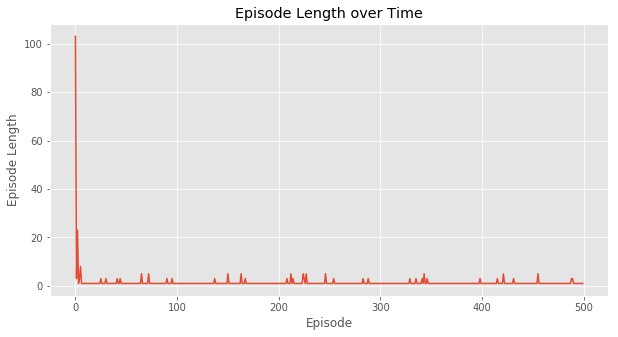

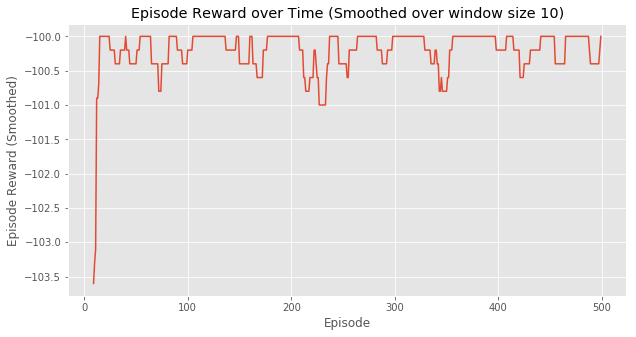

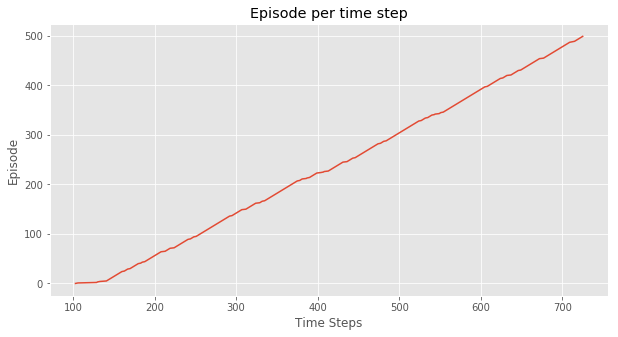

(<Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>,
 <Figure size 720x360 with 1 Axes>)

In [11]:
plotting.plot_episode_stats(stats)